In [ ]:
! pip install surprise

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from surprise.model_selection import train_test_split
from surprise import Dataset
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from surprise import accuracy
from surprise import KNNWithMeans

In [2]:
df = pd.read_csv('ratings_Electronics.csv')

In [3]:
df.shape

(7824481, 4)

In [5]:
df = df.rename(columns ={'AKM1MP6P0OYPR': 'userId', '0132793040': 'productId', '5.0':'Rating','1365811200': 'timestamp' })

In [6]:
df['Rating'].describe().transpose()

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [7]:
df.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


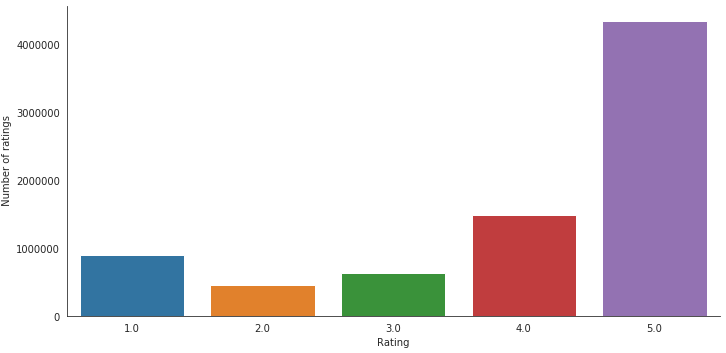

In [8]:
# Checking how the Ratings are distributed
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data = df, aspect=2.0,kind='count')
    g.set_ylabels(" Number of ratings")

The Timestamp column is not much of essence so we would be dropping it.

In [9]:
df.pop("timestamp")

0          1341100800
1          1367193600
2          1374451200
3          1334707200
4          1397433600
              ...    
7824476    1396569600
7824477    1313366400
7824478    1404172800
7824479    1297555200
7824480    1312675200
Name: timestamp, Length: 7824481, dtype: int64

In [10]:
df.head()

,userId,productId,Rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [12]:
users = df['userId'].unique()

In [13]:
len(users)

4201696

We are having 4201696 users in our dataset.

In [14]:
products = df['productId'].unique()

In [15]:
len(products)

476001

We have 476001 products in our dataset.

In [16]:
df.groupby('productId')['Rating'].mean().head()

productId
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
Name: Rating, dtype: float64

In [17]:
df.groupby('productId')['Rating'].mean().sort_values(ascending= False).head()

productId
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: Rating, dtype: float64

In [18]:
df.groupby('productId')['Rating'].count().sort_values(ascending= False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [19]:
df.groupby('userId')['Rating'].count().sort_values(ascending= False).head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [20]:
rating_count_from_users = df.groupby('userId').size().sort_values(ascending = False)[:20]

#Getting a subset of users who have rated the most number of times

In [21]:
print(rating_count_from_users )

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
dtype: int64


In [64]:
df1 = df.iloc[:50000,0:]
#taking a subset from the data frame as the data set is too huge 

In [65]:
df1.shape

(50000, 3)

In [66]:
users = df1['userId'].unique()

In [67]:
len(users)

46554

The subset from the Data frame has 46554 users

In [68]:
users = df1['productId'].unique()

In [69]:
len(users)

3445

The subset from the Data frame has 3445 products

In [70]:
#We would be constructing a Pivot Table which would help us visualize better than how the ratings are distributed 
final_ratings_matrix = df1.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
final_ratings_matrix.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00004THQ7,B00004THQE,B00004THXT,B00004THXV,B00004TISI,B00004TIZS,B00004TIZT,B00004TIZW,B00004TJ0G,B00004TJ0L
userId,,,,,,,,,,,,,,,,,,,,,
A001944026UMZ8T3K5QH1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00766851QZZUBOVF4JFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01255851ZO1U93P8RKGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A014623426J5CM7M12MBW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01580702BRW77PSJ9X34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This suggests that many of the User haven't rated many Products, Thus the unrated products are getting shown as Zeros. Making the Rating Matrix sparse.

In [71]:
print('Shape of the Rating Matrix', final_ratings_matrix.shape)

Shape of the Rating Matrix (46554, 3445)


In [72]:
train_data, test_data = train_test_split(df1, test_size = 0.3, random_state=0)

In [73]:
print(train_data.head())

               userId   productId  Rating
17967   AIHZ3Q0LU3GYK  B00000JYWQ     5.0
32391  A2T4OSK0G5PL24  B000030068     5.0
9341   A115P78ZW1I5E8  B00000J0D2     1.0
7929   A3HYF6WCIP4XXR  B000001ON6     3.0
46544   ASBP0Y6V2DL8X  B00004TB3W     5.0


# Popularity based Recommender system

In [31]:
#Aggregating the number of times a Product has been rated by any user.
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,0321732944,1
1,0439886341,1
2,0511189877,5
3,0528881469,19
4,0558835155,1
5,059400232X,3
6,0594012015,6
7,0594017343,1
8,0594033896,5
9,0594033926,9


In [105]:
#Sorting of the  products on the score which we got from the previous step

train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 


In [104]:
#Generating a ranking based on the score

train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          


In [106]:
#Get the top 10 recommendations from our training data and storing into a new variable (popular_recommendations)
popular_recommendations = train_data_sort.head(10) 
popular_recommendations

,productId,score
1813,B00001P4ZH,1423
2893,B00004T8R2,1167
1943,B00001WRSJ,1131
31,0972683275,734
2605,B00004SB92,726
2599,B00004SABB,723
3032,B00004THCZ,570
1806,B00001P4XA,405
51,1400532655,337
1654,B00000K2YR,328


In [34]:
# Create a function for recommending popular products to users
def recommend(user_id):     
    user_recommendations = popular_recommendations #Assigning the popular recommendations to all the user indexes
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [35]:
find_recom = [10,170,650]   # Choose any user  
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

      user_id   productId  score
1813       10  B00001P4ZH   1423
2893       10  B00004T8R2   1167
1943       10  B00001WRSJ   1131
31         10  0972683275    734
2605       10  B00004SB92    726
2599       10  B00004SABB    723
3032       10  B00004THCZ    570
1806       10  B00001P4XA    405
51         10  1400532655    337
1654       10  B00000K2YR    328


The list of recommendations for the userId: 170

      user_id   productId  score
1813      170  B00001P4ZH   1423
2893      170  B00004T8R2   1167
1943      170  B00001WRSJ   1131
31        170  0972683275    734
2605      170  B00004SB92    726
2599      170  B00004SABB    723
3032      170  B00004THCZ    570
1806      170  B00001P4XA    405
51        170  1400532655    337
1654      170  B00000K2YR    328


The list of recommendations for the userId: 650

      user_id   productId  score
1813      650  B00001P4ZH   1423
2893      650  B00004T8R2   1167
1943      650  B00001WRSJ

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Since the Popularity based recommended system gives the same recommendations of products regardless of any personlisation we are ending up getting the same recommendations for every user.

# Collaborative Filtering Model

In [42]:
train_set, test_set = train_test_split(df1, test_size = 0.15)

In [53]:
df2 = pd.concat([train_data, test_data]).reset_index()
df2.head()

,index,userId,productId,Rating
0,7717,A1M2T6P4TE7CGU,B000001OMA,5.0
1,11450,A1NUAX0GYD3076,B00000J1V5,5.0
2,40225,A3Q5O3IXRGRVML,B00004SB92,5.0
3,655,A11YUH1WVD236C,0972683275,3.0
4,8290,A16FK39DKYY5GZ,B00000DM9W,4.0


In [74]:
#Creating a customised Pivot Table
pivot_df = df2.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00004THQ7,B00004THQE,B00004THXT,B00004THXV,B00004TISI,B00004TIZS,B00004TIZT,B00004TIZW,B00004TJ0G,B00004TJ0L
userId,,,,,,,,,,,,,,,,,,,,,
A001944026UMZ8T3K5QH1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00766851QZZUBOVF4JFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01255851ZO1U93P8RKGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A014623426J5CM7M12MBW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01580702BRW77PSJ9X34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (46554, 3445)


In [78]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00004THQE,B00004THXT,B00004THXV,B00004TISI,B00004TIZS,B00004TIZT,B00004TIZW,B00004TJ0G,B00004TJ0L,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A001944026UMZ8T3K5QH1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A00766851QZZUBOVF4JFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A01255851ZO1U93P8RKGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A014623426J5CM7M12MBW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A01580702BRW77PSJ9X34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [79]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00004THQ7,B00004THQE,B00004THXT,B00004THXV,B00004TISI,B00004TIZS,B00004TIZT,B00004TIZW,B00004TJ0G,B00004TJ0L
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As The Matrix we are getting from the Pivot Table suggest that it is a Sparse Matrix.

So We need to make use of Singular Value Decomposition.

In [81]:
U, sigma, Vtranspose = svds(pivot_df, k = 10)

In [82]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-2.04773179e-19  9.24478499e-20 -2.40142034e-19 ...  4.94679770e-20
  -1.79217237e-20 -2.60048646e-20]
 [-5.45935551e-20  3.41979628e-20 -7.78268553e-20 ...  1.89139457e-20
  -5.20645524e-21 -4.12160422e-21]
 [-1.18894354e-19  1.80044376e-19 -4.18716111e-20 ... -6.88643962e-20
   1.15675601e-19  2.40572767e-19]
 ...
 [ 1.37755146e-10  6.19049270e-09 -1.16774152e-09 ... -1.15624363e-08
   2.43868605e-10  1.48289482e-10]
 [ 8.75306376e-07 -7.07860286e-06  1.59533311e-04 ... -1.87311461e-07
   1.26866765e-07  1.04537533e-07]
 [ 2.56461395e-09 -8.80397987e-07  3.71288999e-07 ... -1.11415799e-08
   3.16058505e-08  2.76503770e-09]]


In [83]:
print('Sigma: \n',sigma)

Sigma: 
 [ 90.1535548   97.2250774   97.71080574 124.97373488 133.02502857
 134.79863203 148.10592059 181.74853167 186.56131867 207.54040294]


Sigma appears to be not a Diagonal Matrix, So we would need to convert it to a Diagonal Matrix.

In [84]:
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 90.1535548    0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          97.2250774    0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          97.71080574   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         124.97373488   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         133.02502857
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  134.79863203   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         148.10592059   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [85]:
#Predicted ratings M= U*E*Vt * So we need to do a dot product of all the three Matrices
predicted_ratings  = np.dot(np.dot(U, sigma), Vtranspose) 
# Convert the predicted ratings into a dataframe
pred_df = pd.DataFrame(predicted_ratings , columns = pivot_df.columns)
pred_df.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00004THQ7,B00004THQE,B00004THXT,B00004THXV,B00004TISI,B00004TIZS,B00004TIZT,B00004TIZW,B00004TJ0G,B00004TJ0L
0,2.665008e-34,9.508907e-37,1.378369e-33,1.843582e-33,1.383706e-34,1.626752e-34,-1.017756e-34,-8.186797e-25,-8.361685e-25,2.698060e-34,...,4.695531e-34,-8.757725e-24,5.940293e-35,2.034420e-34,-9.502115e-35,7.344994e-34,-2.034240e-34,-5.868480e-26,-5.624116e-23,-1.453697e-22
1,9.842288e-35,3.325736e-37,4.141150e-34,6.340969e-34,4.826261e-35,4.192262e-35,-1.540926e-36,-1.851713e-25,-2.566229e-25,7.743275e-35,...,1.629526e-34,-1.171731e-24,9.346484e-36,7.504562e-35,-3.536014e-35,2.378467e-34,-9.607539e-35,-3.030698e-27,-8.862622e-24,-3.587974e-23
2,8.494482e-34,2.021340e-36,-6.001913e-34,1.105994e-33,2.776916e-34,-4.267183e-34,1.534290e-33,2.241161e-24,1.244906e-25,-3.114628e-34,...,9.322268e-34,3.119469e-23,-4.475140e-34,6.278832e-34,-3.093128e-34,1.878329e-34,-1.702418e-33,2.691336e-25,1.969057e-22,2.110572e-22
3,-1.416701e-17,-5.056137e-20,-8.507400e-17,-8.503781e-17,-7.657068e-18,-1.075995e-17,1.052828e-17,4.909861e-08,2.487456e-07,-1.615437e-17,...,-2.651223e-17,-6.895987e-09,-4.516563e-18,-1.071911e-17,5.331697e-18,-3.989217e-17,9.261745e-18,-2.491082e-10,8.268400e-06,8.427005e-06
4,1.934687e-24,4.494479e-27,-7.053050e-24,1.103919e-24,4.581794e-25,-1.779584e-24,5.903196e-24,1.191222e-13,2.874362e-15,-1.822547e-24,...,1.798114e-24,2.175261e-12,-1.815737e-24,1.527948e-24,-8.091854e-25,-1.151096e-24,-4.858479e-24,2.048047e-14,1.092422e-11,1.315809e-11


In [93]:
# Recommend the items which have the highest predicted ratings

def recommend_items(userID, pivot_df, pred_df , num_of_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = pred_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_of_recommendations))

In [94]:
userID = 7
num_of_recommendations = 3
recommend_items(userID, pivot_df, pred_df, num_of_recommendations)


Below are the recommended items for user(user_id = 7):

                   user_ratings  user_predictions
Recommended Items                                
B00002EQCW                  0.0          0.013446
B00000J1V5                  0.0          0.001501
B00000JDF5                  0.0          0.001401


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


# Evaluating the Collaborative Filtering model

In [95]:
final_ratings_matrix.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00004THQ7,B00004THQE,B00004THXT,B00004THXV,B00004TISI,B00004TIZS,B00004TIZT,B00004TIZW,B00004TJ0G,B00004TJ0L
userId,,,,,,,,,,,,,,,,,,,,,
A001944026UMZ8T3K5QH1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00766851QZZUBOVF4JFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01255851ZO1U93P8RKGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A014623426J5CM7M12MBW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01580702BRW77PSJ9X34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
#Mean rating for each of the products
final_ratings_matrix.mean().head()

productId
0321732944    0.000107
0439886341    0.000107
0511189877    0.000580
0528881469    0.001654
0558835155    0.000064
dtype: float64

In [99]:
#Viewing the predicted ratings
pred_df.mean().head()

productId
0321732944    1.106672e-18
0439886341    1.182567e-21
0511189877   -7.435663e-18
0528881469   -6.582249e-18
0558835155    1.504090e-19
dtype: float64

In [101]:
rmse_df = pd.concat([final_ratings_matrix.mean(), pred_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(3445, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0321732944,0.000107,1.106672e-18,0
0439886341,0.000107,1.182567e-21,1
0511189877,0.000580,-7.435663e-18,2
0528881469,0.001654,-6.582249e-18,3
0558835155,0.000064,1.504090e-19,4


In [102]:
#Root Mean Squared Error is the resultant of Actual - Predicted values.
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00299 



# Getting top 5 products to recommend to all the users.

In [103]:
userId = 103 #User for which we would be recommending items
num_of_recommendations = 5
recommend_items(userId, pivot_df, pred_df, num_of_recommendations)


Below are the recommended items for user(user_id = 103):

                   user_ratings  user_predictions
Recommended Items                                
0972683275                  0.0      4.765597e-17
B00000K2YR                  0.0      1.381074e-17
B00004THCZ                  0.0      1.095404e-17
B00001P4XA                  0.0      1.043554e-17
B000026D8E                  0.0      8.052457e-20


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


# Summarizing Insights

Popularity based recommended systems recommend items which have been consistently rated highly by people who might have used or purchased the given set of products, this system does not take into account A particular person's previous preferences or choices he/she might have made. It just puts forward the items that have a high mean rating given that they have been rated by a minimum numbers of users.

Collaborative Filtering methods is also quite close to it's name wherein the Collaborative methods it may imploy can be within the user-user spectrum or item-item spectrum. It gives the products which are either close to user's past purchase or preference history or soughts the preference by grouping users who have had rated the same product before. 

We see clearly from our models that Polpularity based system gives us the same products for every user whereas the products recommended by the collaborative filter model appears to be more customised and the products are different to the ones recommended by Polpularity based model.

              ------------------------*******************------------------------------